In [56]:
import pandas as pd

df = pd.read_csv("../data/clean_data.csv")
df.drop(['Unnamed: 0', 'female_population_pct', 'male_population_pct'], axis=1, inplace=True)
list(df)


['name',
 'alpha_2',
 'year',
 'population',
 'GDP',
 'life_expectancy',
 'net_migration',
 'internet_users_pct',
 'human_capital_index',
 'school_enroll_secondary_gpi',
 'urban_population_pct',
 'infant_mortality_rate']

In [ ]:
df.head(3)

,name,alpha_2,year,population,GDP,life_expectancy,net_migration,internet_users_pct,human_capital_index,school_enroll_secondary_gpi,urban_population_pct,infant_mortality_rate
0,Afghanistan,AF,2000,20130327.0,174.930991,55.005,-1025973,0.00469,0.389,0.027799,22.078,110.1
1,Afghanistan,AF,2001,20284307.0,138.706822,55.511,-212872,0.00472,0.389,0.000000,22.169,107.0
2,Afghanistan,AF,2002,21378117.0,178.954088,56.225,860349,0.00456,0.389,0.175380,22.261,103.8
3,Afghanistan,AF,2003,22733049.0,198.871116,57.171,247317,0.08790,0.389,0.350760,22.353,100.6
4,Afghanistan,AF,2004,23560654.0,221.763654,57.810,-269194,0.10600,0.389,0.209610,22.500,97.2


In [58]:
import pandas as pd

FEATURES = [
    # "GDP",
    "life_expectancy",
    "net_migration",
    "internet_users_pct",
    "human_capital_index",
    "school_enroll_secondary_gpi",
    "urban_population_pct",
    "infant_mortality_rate"
]

def aggregate_periods(df, p, l):
    df = df.sort_values(["name", "year"]).copy()
    out_rows = []
    for name, g in df.groupby("name"):
        g = g.reset_index(drop=True)
        n = len(g)
        for start in range(0, n - (p + l), p):  
            end = start + p - 1
            future = start + p + l - 1
            if future >= n:
                break
            row = {"name": name}
            row["year_start"] = g.loc[start, "year"]
            row["year_end"] = g.loc[end, "year"]

            for f in FEATURES:
                if f not in g.columns:
                    continue
                val_start = g.loc[start, f]
                val_end = g.loc[end, f]
                row[f"{f}_chg"] = val_end - val_start

            gdp_start = g.loc[start, "GDP"]
            gdp_future = g.loc[future, "GDP"]
            row["X"] = gdp_future - gdp_start

            out_rows.append(row)

    return pd.DataFrame(out_rows)


aggregate_periods(df, 5, 5)

,name,year_start,year_end,life_expectancy_chg,net_migration_chg,internet_users_pct_chg,human_capital_index_chg,school_enroll_secondary_gpi_chg,urban_population_pct_chg,infant_mortality_rate_chg,X
0,Afghanistan,2000,2004,2.805,756779,0.10131,0.000000,0.181811,0.422,-12.9,277.122714
1,Afghanistan,2005,2009,2.001,-311573,2.33000,0.000000,0.154930,0.825,-13.7,370.870693
2,Afghanistan,2010,2014,1.558,401373,3.00000,0.000000,0.058550,0.850,-10.5,-64.019001
3,Albania,1980,1984,1.081,665,0.00000,0.000000,0.037630,1.055,-15.9,107.387858
4,Albania,1985,1989,1.175,-38652,0.00000,0.000000,0.018290,1.075,-8.6,-53.449769
...,...,...,...,...,...,...,...,...,...,...,...
1410,Zimbabwe,1990,1994,-5.782,-179671,0.00174,0.000000,-0.060510,2.347,3.4,-284.483039
1411,Zimbabwe,1995,1999,-4.765,-40915,0.15432,0.000000,0.040000,1.615,0.5,-178.490808
1412,Zimbabwe,2000,2004,0.009,37631,1.69900,0.000000,0.011783,0.536,4.9,172.889303
1413,Zimbabwe,2005,2009,3.180,25523,1.60000,0.000000,0.025524,-0.732,4.1,911.186428


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

FEATURES_CHG = [i + "_chg" for i in FEATURES]

def analyze_regression(df):

    features = [f for f in FEATURES_CHG if f in df.columns]

    sub = df.dropna(subset=features + ["X"]).copy()
    if sub.empty:
        raise ValueError("No valid rows after dropping NaNs.")

    X = sub[features].values
    y = sub["X"].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = LinearRegression()
    model.fit(X_scaled, y)

    coefs = pd.Series(model.coef_, index=features, name="predictive_power")

    r2 = r2_score(y, model.predict(X_scaled))

    result = coefs.to_frame().T
    result["R2"] = r2

    cols = ["R2"] + features
    result = result.reindex(columns=cols, fill_value=None)

    return result

analyze_regression(aggregate_periods(df, 5, 5))


,R2,life_expectancy_chg,net_migration_chg,internet_users_pct_chg,human_capital_index_chg,school_enroll_secondary_gpi_chg,urban_population_pct_chg,infant_mortality_rate_chg
predictive_power,0.169551,725.646607,231.270347,2110.435805,-641.100955,10.778275,-398.788841,1031.923274


Investigation periods: 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]



Best combination → Investigation period = 11.0 yrs, GDP lag = 9.0 yrs, R² = 0.366
Predictivities (feature → standardized coefficient):
  life_expectancy_chg                   1846.369
  net_migration_chg                      242.231
  internet_users_pct_chg                5265.496
  human_capital_index_chg              -1266.843
  school_enroll_secondary_gpi_chg       -224.839
  urban_population_pct_chg              -301.505
  infant_mortality_rate_chg             2922.299


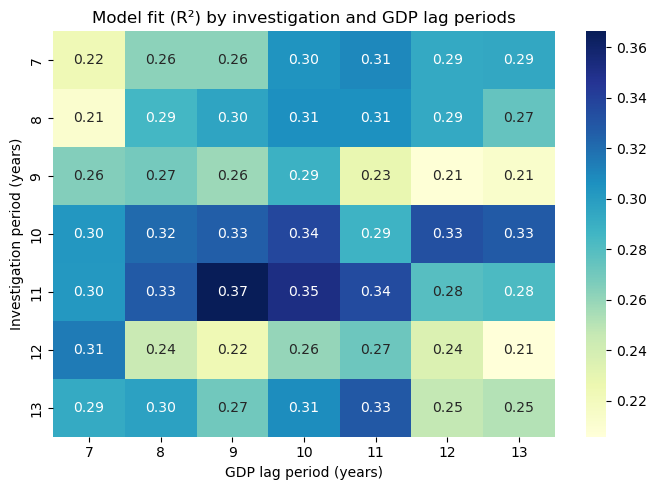

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

results = []
coeffs = []
ind = -1
for P in tqdm(range(7, 14), desc="Investigation periods"):
    for L in range(7, 14):
        try:
            ind += 1
            df_agg = aggregate_periods(df, p=P, l=L)
            res = analyze_regression(df_agg)
            r2 = res.loc["predictive_power", "R2"] if "predictive_power" in res.index else res["R2"].iloc[0]
            results.append((P, L, r2, ind))
            coeffs.append(res)
        except Exception as e:
            print(f"Skipped P={P}, L={L} due to error: {e}")

res_df = pd.DataFrame(results, columns=["investigation_period", "gdp_lag_period", "R2", "index"])

best = res_df.loc[res_df["R2"].idxmax()]
bests_coeffs = coeffs[int(best["index"])]
print(f"\nBest combination → Investigation period = {best['investigation_period']} yrs, "
      f"GDP lag = {best['gdp_lag_period']} yrs, R² = {best['R2']:.3f}")

print("Predictivities (feature → standardized coefficient):")
for feat in FEATURES_CHG:
    val = float(bests_coeffs.loc["predictive_power", feat]) if "predictive_power" in bests_coeffs.index else float(bests_coeffs[feat])
    print(f"  {feat:<35s} {val:>10.3f}")

plt.figure(figsize=(7,5))
pivot = res_df.pivot(index="investigation_period", columns="gdp_lag_period", values="R2")
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Model fit (R²) by investigation and GDP lag periods")
plt.ylabel("Investigation period (years)")
plt.xlabel("GDP lag period (years)")
plt.tight_layout()
plt.show()
